# *Libraries*


In [80]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Import for custom tick formatting
import seaborn as sns

# *Functions*

In [2]:
def plot_feature_predictive_power(dataframe, feature, target, n_quantiles=20, categorical=False):
    """
    Plots the predictive power of a feature by dividing it into quantiles 
    and computing the average target value for each quantile.
    
    Args:
        df: DataFrame containing the feature and target data.
        feature: The feature name (string) to investigate.
        target: The target variable name (string).
        n_quantiles: Number of quantiles to divide the feature into.
        categorical: Whether the feature is categorical or continuous
    """
    df = dataframe.copy()

    # Create quantile-based groups
    if categorical:
        df['quantile'] = df[feature]
    else:
        df['quantile'] = pd.qcut(df[feature], q=n_quantiles, duplicates='drop')
    
    # Group by quantiles and calculate mean target value
    quantile_means = round(df.groupby('quantile')[target].mean()*100, 2)
    quantile_means = quantile_means.reset_index()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=quantile_means.index, y=quantile_means[target], marker='o')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))

    if categorical:
        plt.xlabel('Categories')
        plt.xticks(ticks=np.arange(len(quantile_means)), labels=quantile_means['quantile'].astype(str))
    else:
        plt.xlabel('Quantiles')
        plt.xticks(ticks=np.arange(len(quantile_means)), labels=quantile_means['quantile'].astype(str), rotation=45)
        
    plt.ylabel('Percentage of Loan Defaults')
    plt.title(f'Predictive Power of {feature}')
    plt.tight_layout()
    plt.show()

In [3]:
def calculate_psi(expected, actual, buckets=10):
    """
    Calculate the Population Stability Index (PSI) for numerical features.

    PSI measures the difference between two distributions and is commonly used 
    to compare the distribution of a feature in the training dataset (expected) 
    with the distribution in the validation or test dataset (actual).

    Parameters:
        expected (array-like): Array of values from the training dataset.
        actual (array-like): Array of values from the validation/test dataset.
        buckets (int): Number of bins to divide the data into. Default is 10.

    Returns:
        float: The PSI value. A higher value indicates a larger divergence 
               between the two distributions.
    """
    # Step 1: Create breakpoints using percentiles of the expected data
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))

    # Step 2: Calculate the percentage of data points in each bin
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    # Step 3: Handle zero percentages to avoid division by zero or log(0)
    epsilon = 1e-10
    expected_percents = np.clip(expected_percents, epsilon, None)
    actual_percents = np.clip(actual_percents, epsilon, None)

    # Step 4: Calculate PSI for each bin and sum the results
    psi_value = np.sum((expected_percents - actual_percents) * 
                       np.log(expected_percents / actual_percents))

    return round(psi_value, 2)

def calculate_categorical_psi(train_values, valid_values):
    """
    Calculate the Population Stability Index (PSI) for categorical features.

    PSI measures the difference between two categorical distributions, 
    typically between the training dataset (expected) and the validation 
    or test dataset (actual).

    Parameters:
        train_values (pd.Series): Value counts of the feature in the training dataset, normalized to proportions.
        valid_values (pd.Series): Value counts of the feature in the validation/test dataset, normalized to proportions.

    Returns:
        float: The PSI value. A higher value indicates a larger divergence 
               between the two distributions.
    """
    # Step 1: Get all unique categories present in either dataset
    categories = set(train_values.index).union(set(valid_values.index))

    # Step 2: Initialize PSI value
    psi_value = 0
    epsilon = 1e-10

    # Step 3: Iterate through all categories and calculate PSI contribution
    for category in categories:
        train_percent = train_values.get(category, 0)  # Proportion in train
        valid_percent = valid_values.get(category, 0)  # Proportion in validation
        psi_value += (train_percent - valid_percent) * \
                     np.log((train_percent + epsilon) / (valid_percent + epsilon))

    return round(psi_value, 2)

In [4]:
def plot_feature_type_counts(dataframe):
    """
    Plot the count of categorical and numerical features in a dataframe.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The input dataframe to analyze
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created plot figure
    """
    # Determine feature types
    categorical_features = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Create a DataFrame for plotting
    feature_type_counts = pd.DataFrame({
        'Feature Type': ['Categorical', 'Numerical'],
        'Count': [len(categorical_features), len(numerical_features)]
    })
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Feature Type', y='Count', data=feature_type_counts, palette='Set2')
    
    # Customize the plot
    plt.title('Count of Categorical vs Numerical Features', fontsize=15)
    plt.xlabel('Feature Type', fontsize=12)
    plt.ylabel('Number of Features', fontsize=12)
    
    # Add count labels on top of each bar
    for i, count in enumerate(feature_type_counts['Count']):
        plt.text(i, count, str(count), 
                 ha='center', va='bottom', 
                 fontweight='bold')
    
    plt.tight_layout()
    return plt.gcf()

In [5]:
def plot_dataset_split(train_size, val_size, test_size, title='Dataset Split'):
    """
    Create a pie chart visualizing the proportions of train, validation, and test splits.
    
    Parameters:
    -----------
    train_size : int
        Number of samples in the training set
    val_size : int
        Number of samples in the validation set
    test_size : int
        Number of samples in the test set
    title : str, optional
        Title of the pie chart (default is 'Dataset Split')
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created pie chart figure
    """
    # Prepare data for plotting
    sizes = [train_size, val_size, test_size]
    total = sum(sizes)
    
    # Create custom labels with both percentage and count
    labels = [
        f'Train\n{sizes[0]} ({sizes[0]/total*100:.1f}%)', 
        f'Validation\n{sizes[1]} ({sizes[1]/total*100:.1f}%)', 
        f'Test\n{sizes[2]} ({sizes[2]/total*100:.1f}%)'
    ]
    
    # Color palette
    colors = ['#FF9999', '#66B2FF', '#99FF99']
    
    # Create pie chart
    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, colors=colors, 
            autopct=lambda p: f'{p:.1f}%' if p > 0 else '', 
            startangle=90, explode=(0.1, 0, 0))
    
    # Add title
    plt.title(title, fontsize=15)
    
    # Add total samples information
    plt.text(0, -1.2, f'Total Samples: {total}', 
             horizontalalignment='center', 
             fontsize=10)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')
    
    return plt.gcf()

# *Data Preprocessing*

**Import dataset**

In [8]:
df = pd.read_csv('DATA/credit_risk_dataset.csv', low_memory=False)

In [9]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**Check Duplicated Rows**

In [11]:
df.shape, df.drop_duplicates().shape

((32581, 12), (32416, 12))

In [12]:
# Drop duplicates
df = df.drop_duplicates(ignore_index=True)

In [13]:
# create unique ID for each row
df['ID'] = np.arange(1, len(df) + 1)

C:\Users\User\AppData\Local\Temp\ipykernel_12308\437358331.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='loan_status', palette='Set2')


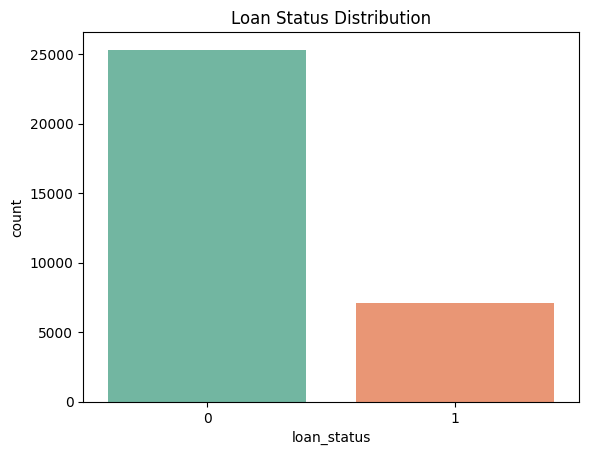

In [14]:
# Target variable distribution
sns.countplot(data=df, x='loan_status', palette='Set2')
plt.title('Loan Status Distribution')
plt.show()

## *Split Dataset Train-Test Set*

In [18]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [19]:
train_df.to_csv('DATA/train.csv', index=False)
valid_df.to_csv('DATA/valid.csv', index=False)
test_df.to_csv('DATA/test.csv', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_12308\1807245254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='loan_status', palette='Set2')


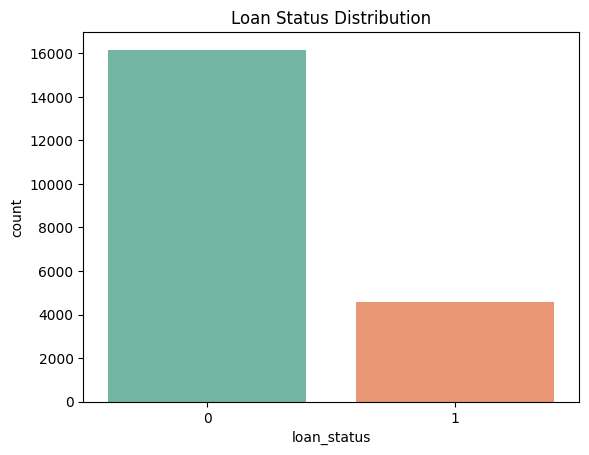

In [60]:
# Target variable distribution
sns.countplot(data=train_df, x='loan_status', palette='Set2')
plt.title('Loan Status Distribution')
plt.show()

## *Categorical Feature Encoding*

We will use the label encoding technique by calculating the mean value of `loan_status` (riskiness) for each category and grouping them based on similar values. Additionally, we will control the number of observations in each group to avoid having less significant groups.

In [126]:
train_df = pd.read_csv('DATA/train.csv')
valid_df = pd.read_csv('DATA/valid.csv')
test_df = pd.read_csv('DATA/test.csv')

In [22]:
categorical_features = list(train_df.select_dtypes(include=['object']).columns)

In [23]:
categorical_features

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

C:\Users\User\AppData\Local\Temp\ipykernel_12308\4023843687.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature Type', y='Count', data=feature_type_counts, palette='Set2')


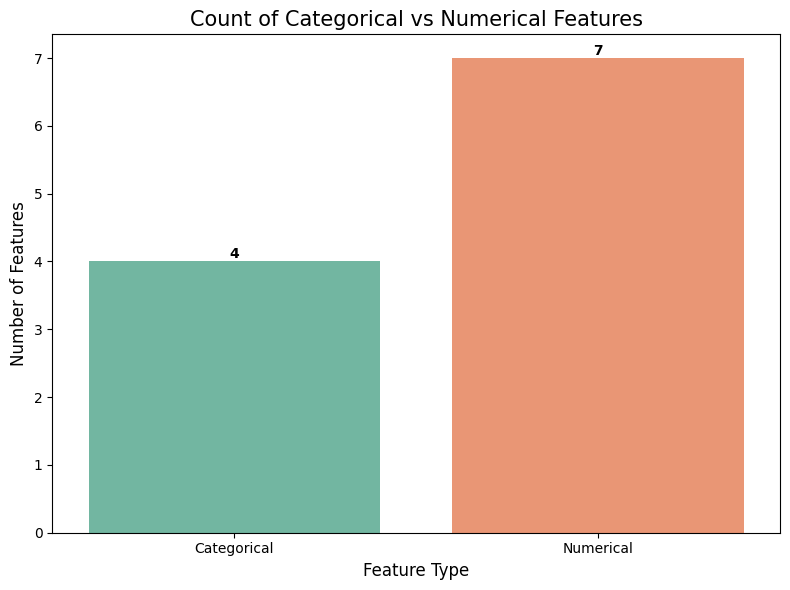

In [24]:
# Plot numerical and categorical feature counts
plot = plot_feature_type_counts(train_df.drop(columns=['ID', 'loan_status']))
plt.show()

In [25]:
train_df.shape, valid_df.shape, test_df.shape

((20745, 13), (5187, 13), (6484, 13))

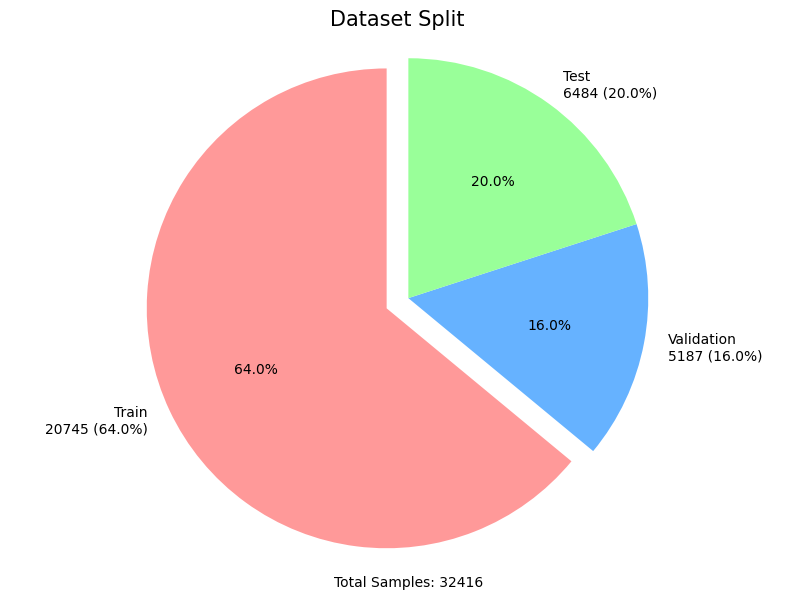

In [26]:
# Plot poportions of the dataset split
plot_dataset_split(train_size=20745, val_size=5187, test_size=6484)
plt.show()

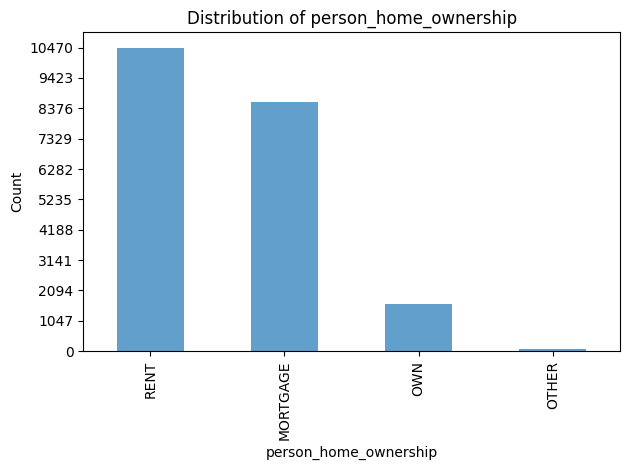

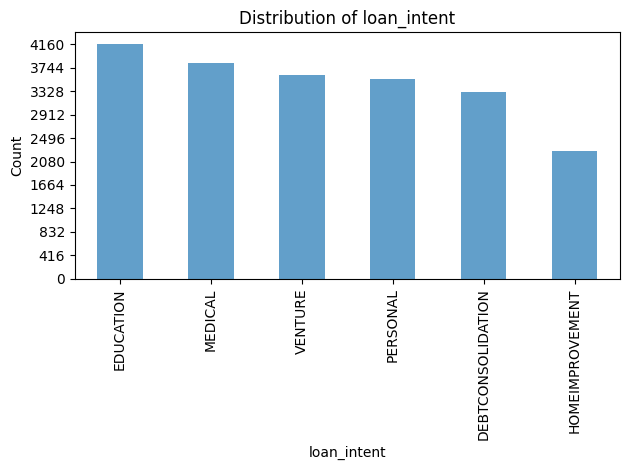

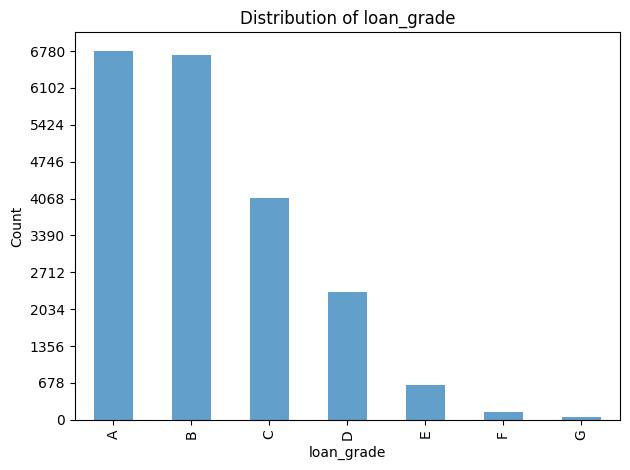

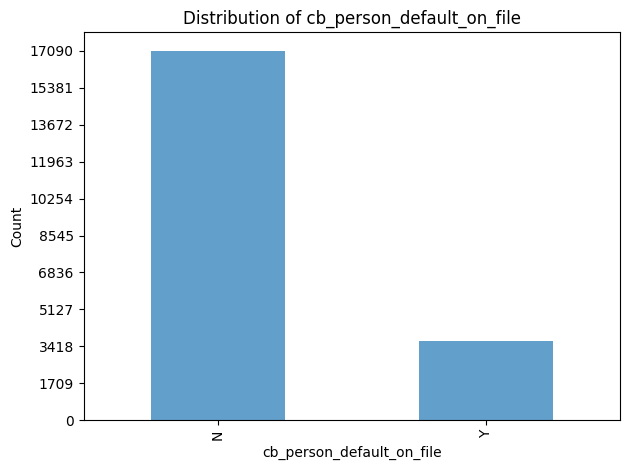

In [27]:
# plot distribution of categorical features

for col in categorical_features:
    value_counts = train_df[col].value_counts()

    value_counts.plot(kind='bar', alpha=0.7)
    
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    
  
    max_count = value_counts.max()
    plt.yticks(np.arange(0, max_count + 1, max(1, max_count // 10))) 
    
    plt.tight_layout()
    plt.show()

**person_home_ownership**

Categories:
- **RENT:** The applicant is renting their residence and does not own property.
- **OWN:** The applicant owns their home outright (no mortgage or debt related to the property).
- **MORTGAGE:** The applicant owns their home but has a mortgage (and thus, a loan obligation tied to the home).
- **OTHER:** Any other arrangement, such as living with family, in employer-provided housing, or in a situation not captured by the main categories.

In [30]:
# Check for categorical values in union of train, valid and test sets and not in train set
set(train_df['person_home_ownership'].unique()).union(set(valid_df['person_home_ownership'].unique())).union(set(test_df['person_home_ownership'].unique())) - set(train_df['person_home_ownership'].unique())

set()

In [31]:
train_df.groupby('person_home_ownership')['loan_status'].agg(['mean', 'count']).sort_values(by='mean')

,mean,count
person_home_ownership,,
OWN,0.077351,1616
MORTGAGE,0.130546,8587
OTHER,0.298507,67
RENT,0.315513,10475


In [32]:
# Group and encode categorical feature
map_person_home_ownership = {'OWN': 1, 'MORTGAGE':2, 'RENT':3, 'OTHER':3}

In [33]:
train_df['person_home_ownership'] = train_df['person_home_ownership'].map(map_person_home_ownership)
valid_df['person_home_ownership'] = valid_df['person_home_ownership'].map(map_person_home_ownership)
test_df['person_home_ownership'] = test_df['person_home_ownership'].map(map_person_home_ownership)

In [34]:
train_df['person_home_ownership'].isnull().sum(), valid_df['person_home_ownership'].isnull().sum(), test_df['person_home_ownership'].isnull().sum()

(0, 0, 0)

**loan_intent**

Categories:
- **PERSONAL:** The loan is for personal expenses, such as medical bills, vacations, or other miscellaneous reasons.
- **EDUCATION:** The loan is intended to finance educational expenses like tuition or school supplies.
- **MEDICAL:** The loan is meant to cover medical expenses, such as hospital bills or surgeries.
- **VENTURE:** The loan is requested to fund a business venture or start-up.
- **HOMEIMPROVEMENT:** The loan is intended for home renovations, repairs, or upgrades.
- **DEBTCONSOLIDATION:** The loan is for consolidating other debts, such as credit card balances or existing loans, into one payment.

In [35]:
# Check for categorical values in union of train, valid and test sets and not in train set
set(train_df['loan_intent'].unique()).union(set(valid_df['loan_intent'].unique())).union(set(test_df['loan_intent'].unique())) - set(train_df['loan_intent'].unique())

set()

In [36]:
train_df.groupby('loan_intent')['loan_status'].agg(['mean', 'count']).sort_values(by='mean')

,mean,count
loan_intent,,
VENTURE,0.149225,3612
EDUCATION,0.171669,4165
PERSONAL,0.208169,3550
HOMEIMPROVEMENT,0.259912,2270
MEDICAL,0.267032,3831
DEBTCONSOLIDATION,0.290926,3317


In [37]:
# Group and encode categorical feature
map_loan_intent = {'VENTURE': 1, 'EDUCATION':2, 'PERSONAL':3, 'HOMEIMPROVEMENT':4, 'MEDICAL':5, 'DEBTCONSOLIDATION':6}

In [38]:
train_df['loan_intent'] = train_df['loan_intent'].map(map_loan_intent)
valid_df['loan_intent'] = valid_df['loan_intent'].map(map_loan_intent)
test_df['loan_intent'] = test_df['loan_intent'].map(map_loan_intent)

In [39]:
train_df['loan_intent'].isnull().sum(), valid_df['loan_intent'].isnull().sum(), test_df['loan_intent'].isnull().sum()

(0, 0, 0)

**loan_grade**

- Loan grades are  represented as letters (e.g., A, B, C, D, E, F, G).
- Higher grades (e.g., A) indicate a lower credit risk and better creditworthiness.
- Lower grades (e.g., F, G) indicate higher credit risk and lower creditworthiness.

In [40]:
# Check for categorical values in union of train, valid and test sets and not in train set
set(train_df['loan_grade'].unique()).union(set(valid_df['loan_grade'].unique())).union(set(test_df['loan_grade'].unique())) - set(train_df['loan_grade'].unique())

set()

In [41]:
train_df.groupby('loan_grade')['loan_status'].agg(['mean', 'count']).sort_values(by='mean')

,mean,count
loan_grade,,
A,0.102005,6784
B,0.166766,6710
C,0.209559,4080
D,0.576972,2345
E,0.636076,632
F,0.708609,151
G,1.000000,43


In [43]:
# Group and encode categorical feature
map_loan_grade = {'A': 1, 'B':2, 'C':3, 'D':4, 'E':4, 'F':4, 'G':4}

In [44]:
train_df['loan_grade'] = train_df['loan_grade'].map(map_loan_grade)
valid_df['loan_grade'] = valid_df['loan_grade'].map(map_loan_grade)
test_df['loan_grade'] = test_df['loan_grade'].map(map_loan_grade)

In [47]:
train_df['loan_grade'].isnull().sum(), valid_df['loan_grade'].isnull().sum(), test_df['loan_grade'].isnull().sum()

(0, 0, 0)

**cb_person_default_on_file**

The feature `cb_person_default_on_file` likely refers to whether the person has a record of previously defaulting on a loan or financial obligation. It indicates the borrower's historical default behavior, which is a critical factor in assessing their credit risk.

Categories:
- **"Y" (Yes):** The borrower has a history of defaulting on a loan or financial obligation.
- **"N" (No):** The borrower does not have any history of defaulting.

In [48]:
# Check for categorical values in union of train, valid and test sets and not in train set
set(train_df['cb_person_default_on_file'].unique()).union(set(valid_df['cb_person_default_on_file'].unique())).union(set(test_df['cb_person_default_on_file'].unique())) - set(train_df['cb_person_default_on_file'].unique())

set()

In [49]:
train_df.groupby('cb_person_default_on_file')['loan_status'].agg(['mean', 'count']).sort_values(by='mean')

,mean,count
cb_person_default_on_file,,
N,0.187317,17094
Y,0.374966,3651


In [50]:
# Group and encode categorical feature
map_cb_person_default_on_file = {'N': 1, 'Y':2}

In [51]:
train_df['cb_person_default_on_file'] = train_df['cb_person_default_on_file'].map(map_cb_person_default_on_file)
valid_df['cb_person_default_on_file'] = valid_df['cb_person_default_on_file'].map(map_cb_person_default_on_file)
test_df['cb_person_default_on_file'] = test_df['cb_person_default_on_file'].map(map_cb_person_default_on_file)

In [52]:
train_df['cb_person_default_on_file'].isnull().sum(), valid_df['cb_person_default_on_file'].isnull().sum(), test_df['cb_person_default_on_file'].isnull().sum()

(0, 0, 0)

**Save Transformed Data**

In [53]:
train_df.to_csv('DATA/encoded_train.csv', index=False)
valid_df.to_csv('DATA/encoded_valid.csv', index=False)
test_df.to_csv('DATA/encoded_test.csv', index=False)

In [54]:
train_df['loan_status'].value_counts(normalize=True)

0    0.779658
1    0.220342
Name: loan_status, dtype: float64

In [55]:
valid_df['loan_status'].value_counts(normalize=True)

0    0.786582
1    0.213418
Name: loan_status, dtype: float64

In [56]:
test_df['loan_status'].value_counts(normalize=True)

0    0.782387
1    0.217613
Name: loan_status, dtype: float64

## *Numerical Feature Preprocessing*

In [98]:
train_df = pd.read_csv('DATA/encoded_train.csv', low_memory=False)
valid_df = pd.read_csv('DATA/encoded_valid.csv', low_memory=False)
test_df = pd.read_csv('DATA/encoded_test.csv', low_memory=False)    

In [99]:
train_df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              569
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2024
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
ID                               0
dtype: int64

In [100]:
numerical_features = [i for i in train_df.select_dtypes(include='number').columns if i not in ['loan_status', 'ID'] + categorical_features]
target_variable = 'loan_status'

### Outlier Capping

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


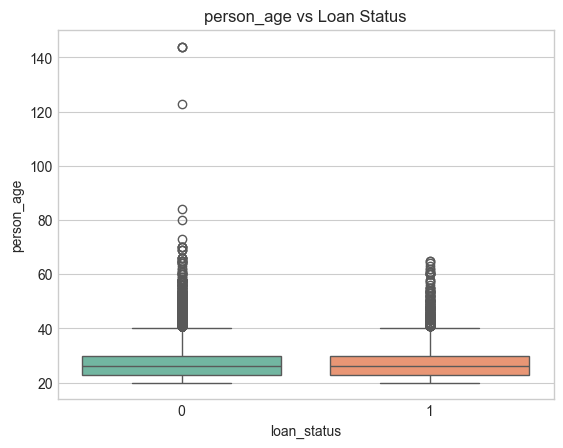

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


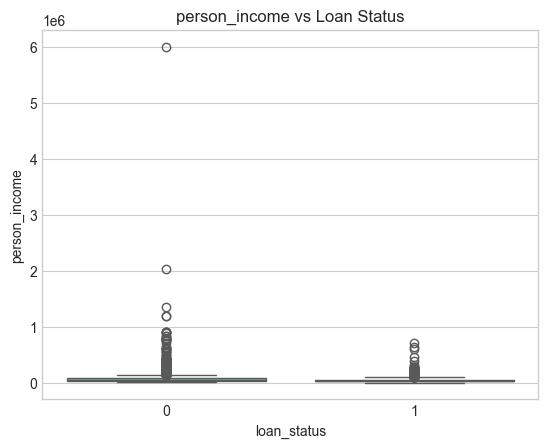

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


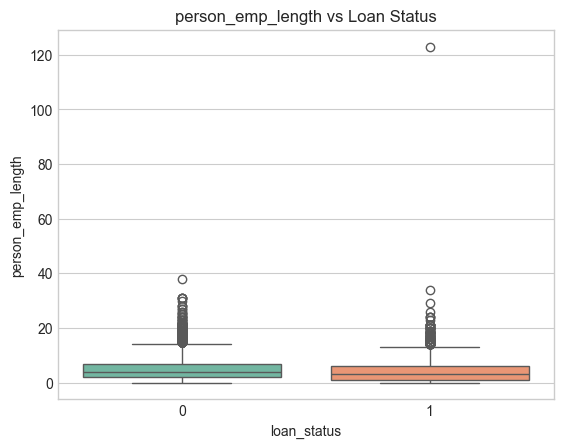

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


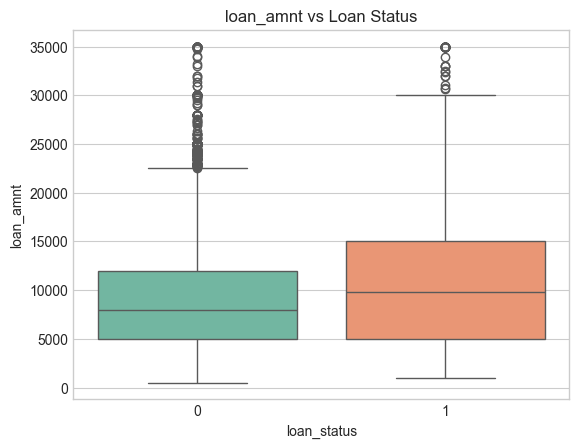

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


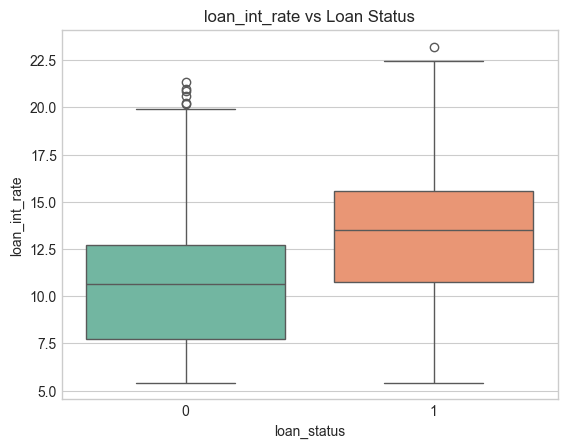

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


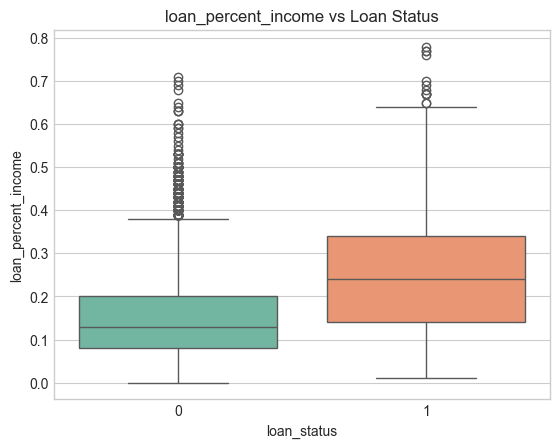

C:\Users\User\AppData\Local\Temp\ipykernel_12308\3235808752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')


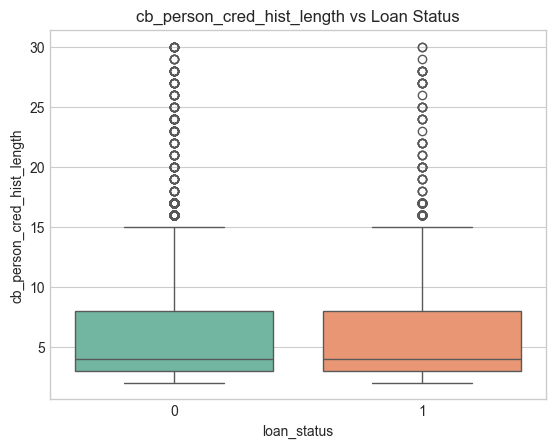

In [101]:
for col in numerical_features:
    sns.boxplot(data=train_df, x='loan_status', y=col, palette='Set2')
    plt.title(f'{col} vs Loan Status')
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


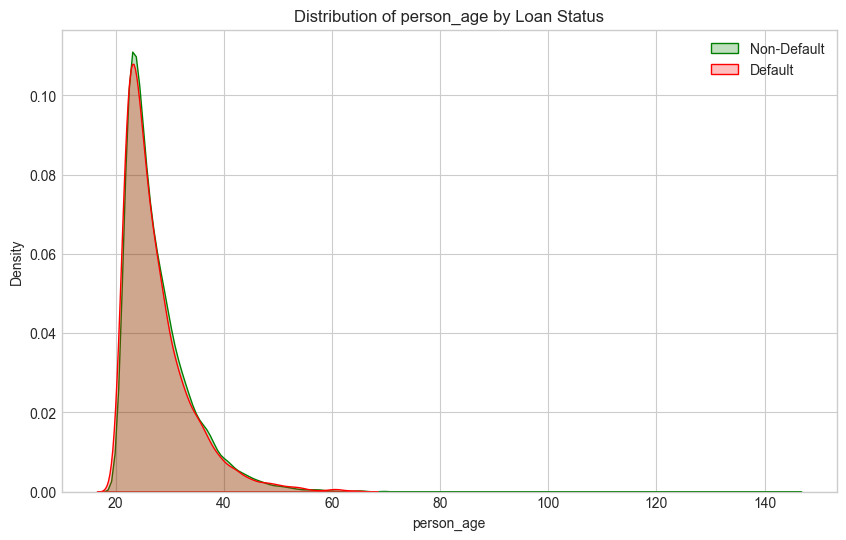

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


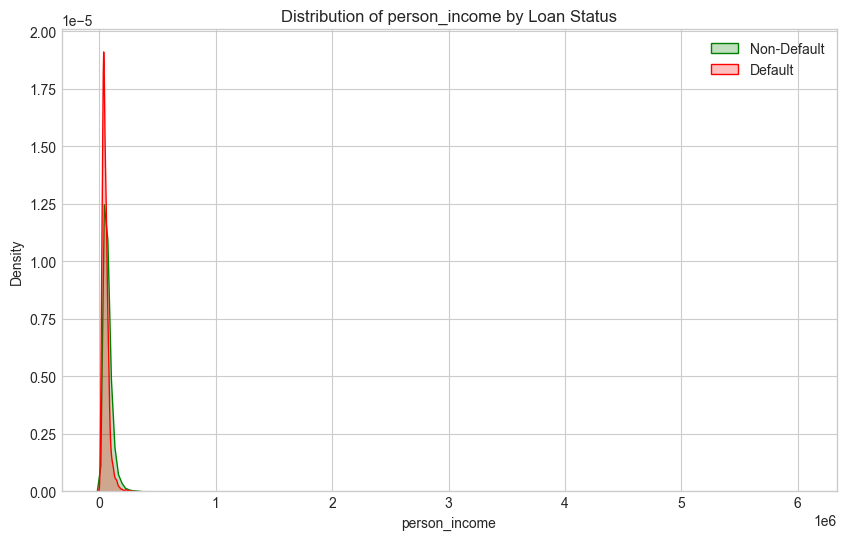

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


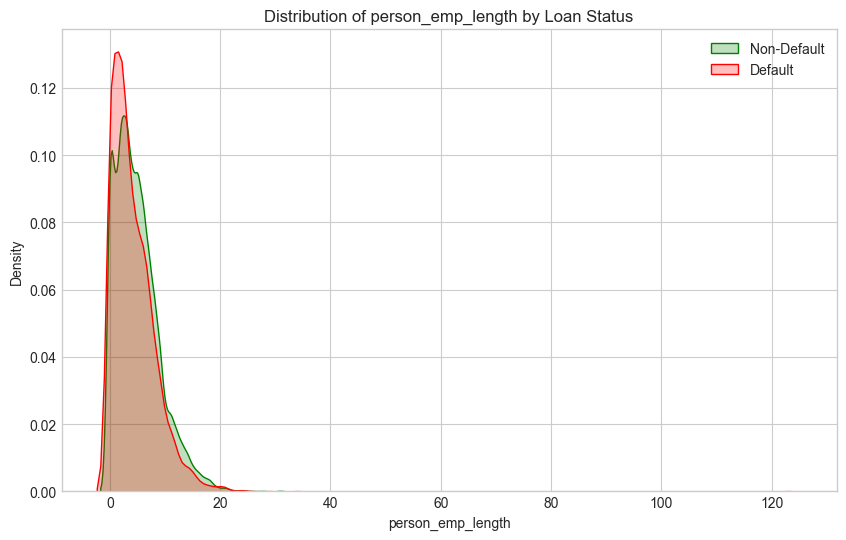

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


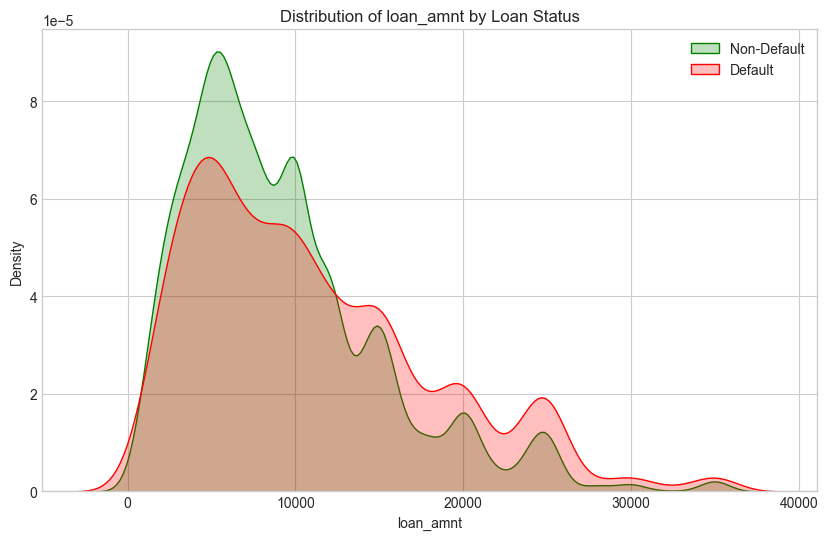

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


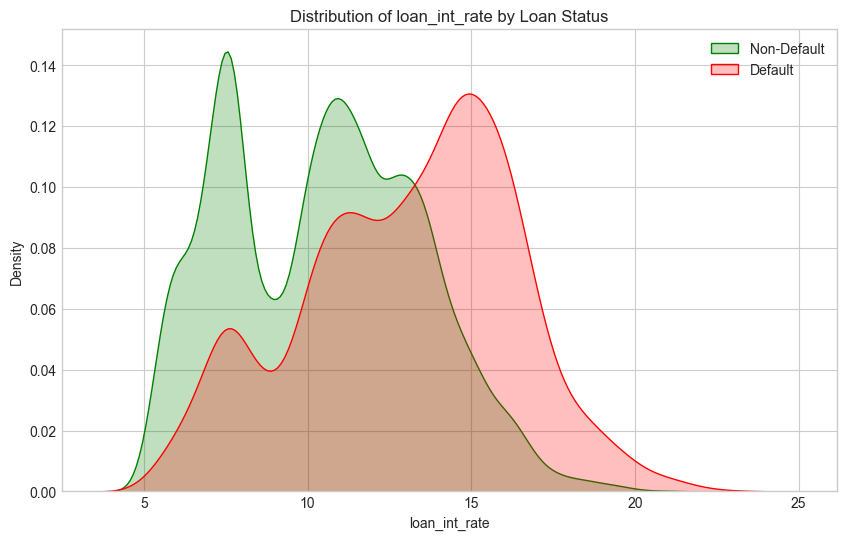

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


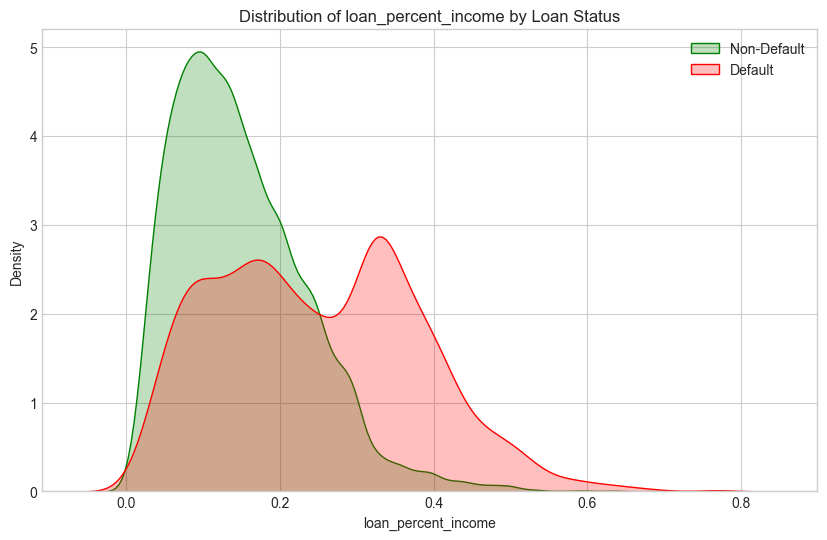

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


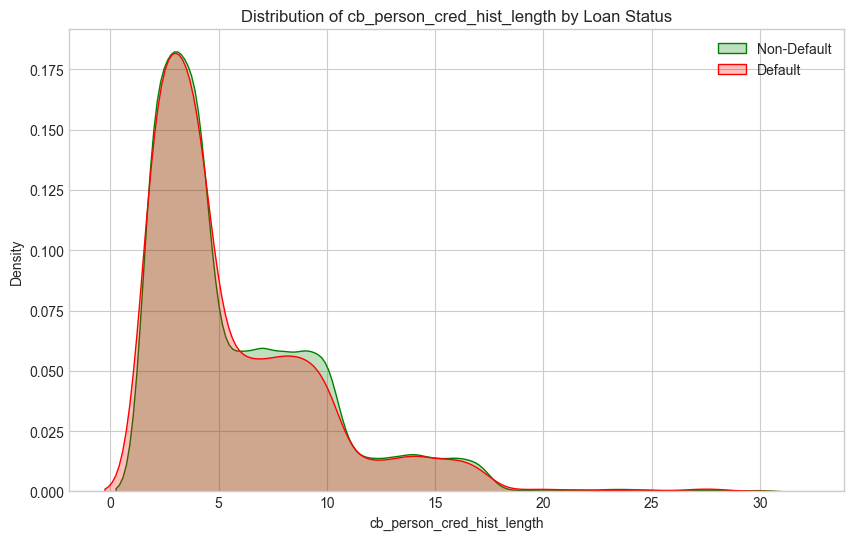

In [102]:
for col in numerical_features:
    plt.figure(figsize=(10, 6))
    
    # Plot KDE for non-default loans
    sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
    
    # Plot KDE for default loans
    sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')
    
    plt.title(f'Distribution of {col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

As we see `person_age`, `person_income` and `person_emp_lenght` contain outlier values.

**Cap outliers in `person_age`, `person_income`, `person_emp_length`**

After reviewing the summary statistics of our numerical features, we identified several variables with highly skewed distributions and potential outliers. For example, `person_age` has a maximum value of 144, which is an impossible age and clearly a data entry error. Similarly, `person_income` has a maximum value that is drastically higher than its 75th percentile, indicating the presence of extreme values.

To mitigate the impact of these outliers, we will apply a common treatment technique known as **percentile capping**. For each numerical feature, we will cap the values that fall below the 1st percentile or above the 99th percentile. This means any value lower than the 1st percentile will be replaced by the value at the 1st percentile, and any value higher than the 99th percentile will be replaced by the value at the 99th percentile.

Crucially, to prevent data leakage, these percentile bounds were calculated using only the training data and then applied consistently across both the training and test sets. This protocol is essential for ensuring that our final model evaluation is unbiased and provides a true measure of its performance on unseen data.

In [104]:
capping_values = {}

for col in numerical_features:
    # Calculate the 1st and 99th percentiles using the training data
    lower_bound = train_df[col].quantile(0.01)
    upper_bound = train_df[col].quantile(0.99)
    
    # Store the bounds in the dictionary
    capping_values[col] = {'lower': lower_bound, 'upper': upper_bound}

print("Calculated Percentile Bounds (from Training Data):")
print(capping_values)

Calculated Percentile Bounds (from Training Data):
{'person_age': {'lower': 21.0, 'upper': 50.0}, 'person_income': {'lower': 14000.0, 'upper': 225000.0}, 'person_emp_length': {'lower': 0.0, 'upper': 17.0}, 'loan_amnt': {'lower': 1000.0, 'upper': 29934.000000000196}, 'loan_int_rate': {'lower': 5.42, 'upper': 18.64}, 'loan_percent_income': {'lower': 0.02, 'upper': 0.5}, 'cb_person_cred_hist_length': {'lower': 2.0, 'upper': 17.0}}


In [ ]:
#  Apply the Capping to Training and Test Sets ---

# Capping the training data
for col in numerical_features:
    lower = capping_values[col]['lower']
    upper = capping_values[col]['upper']
    
    # Using np.clip is efficient for capping values in a range
    train_df[col] = np.clip(train_df[col], lower, upper)


# Capping the validation data using the SAME bounds from the training data
for col in numerical_features:
    lower = capping_values[col]['lower']
    upper = capping_values[col]['upper']
    
    # Apply the same clipping to the validation set
    valid_df[col] = np.clip(valid_df[col], lower, upper)

# Capping the test data using the SAME bounds from the training data
for col in numerical_features:
    lower = capping_values[col]['lower']
    upper = capping_values[col]['upper']
    
    # Apply the same clipping to the test set
    test_df[col] = np.clip(test_df[col], lower, upper)

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


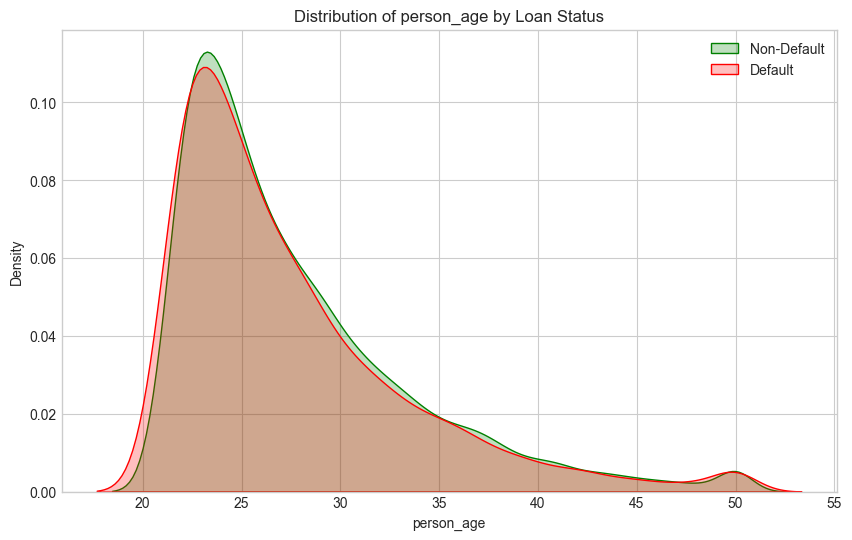

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


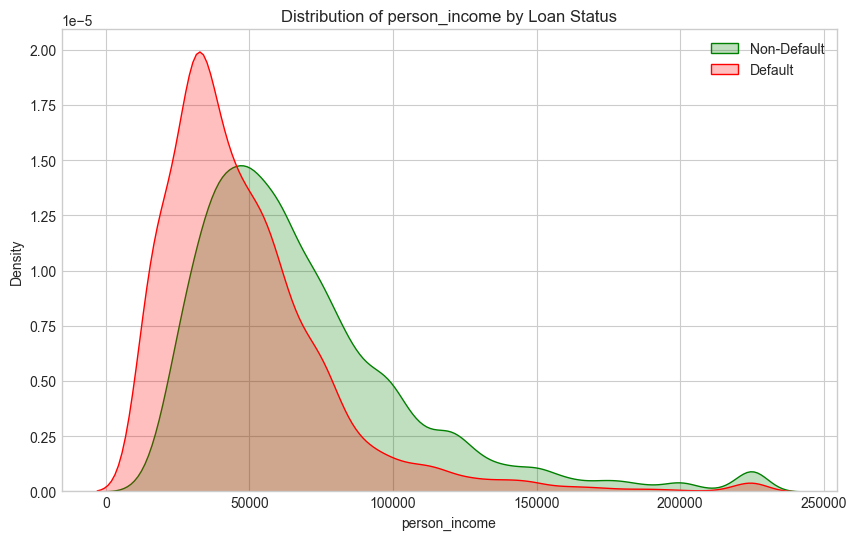

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


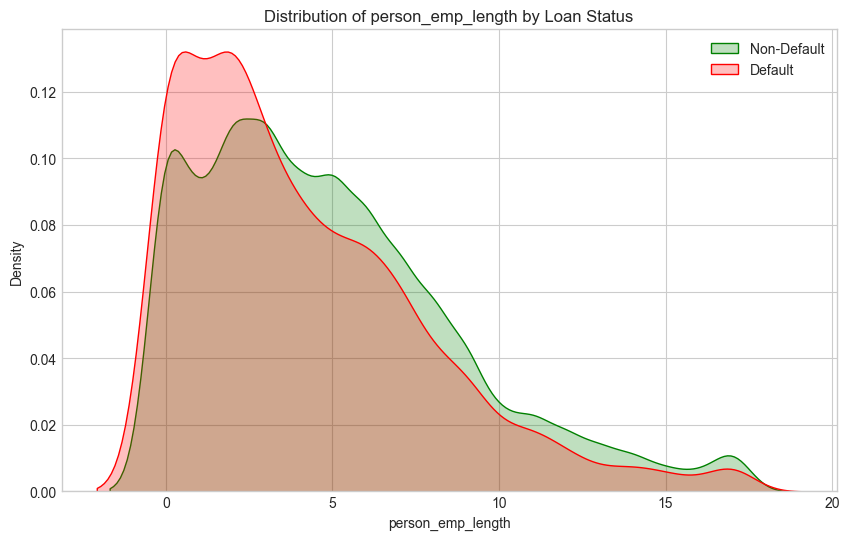

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


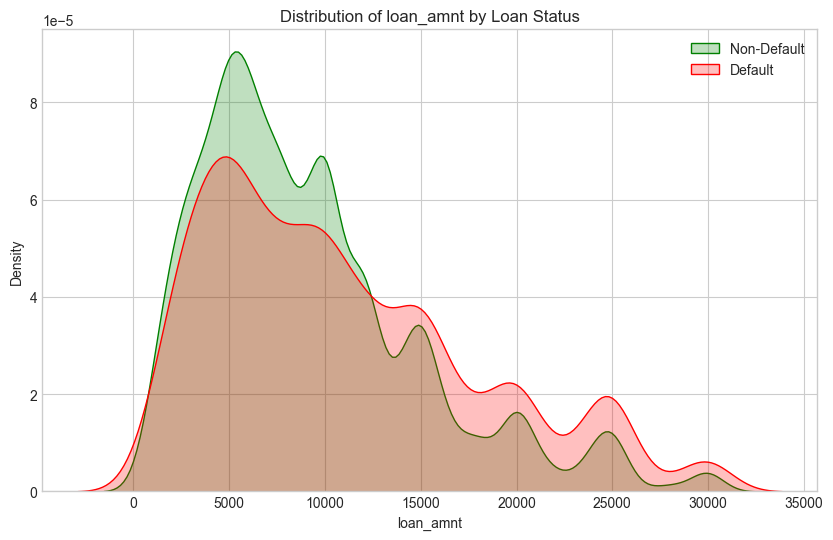

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


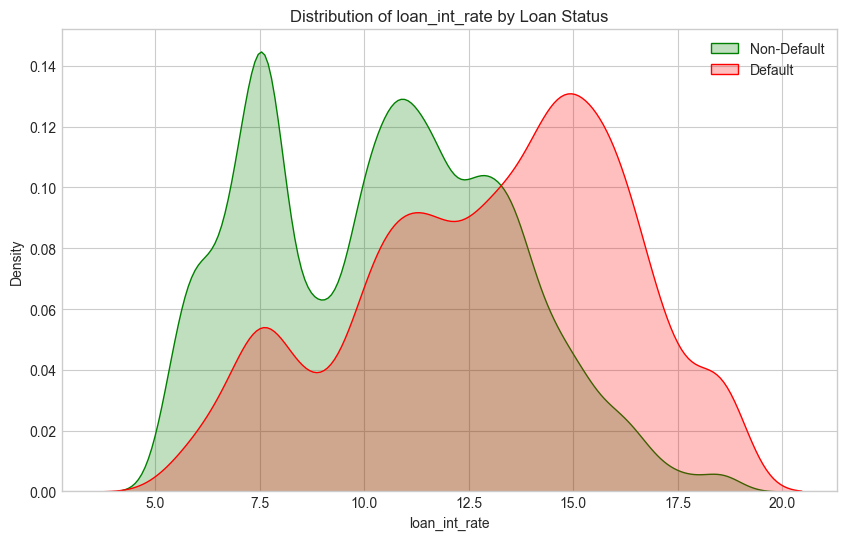

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


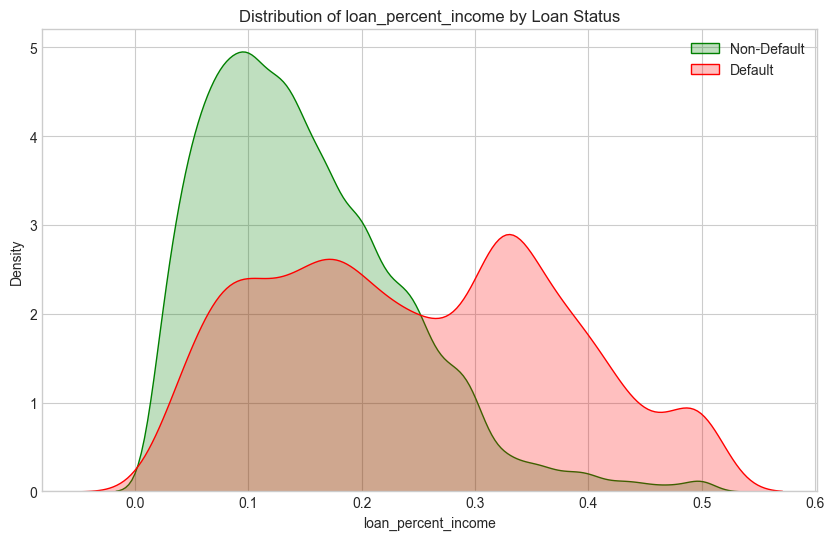

C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
C:\Users\User\AppData\Local\Temp\ipykernel_12308\2407882554.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')


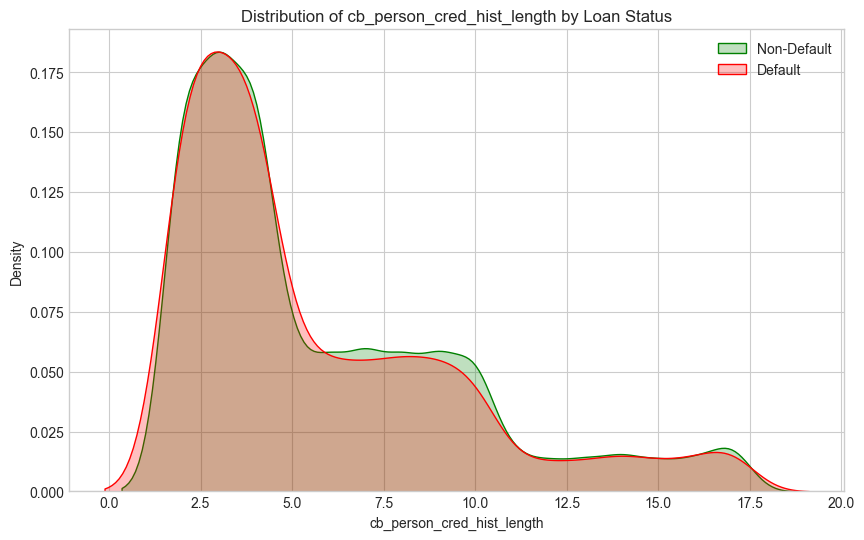

In [106]:
for col in numerical_features:
    plt.figure(figsize=(10, 6))
    
    # Plot KDE for non-default loans
    sns.kdeplot(data=train_df[train_df['loan_status'] == 0], x=col, shade=True, label='Non-Default', color='green')
    
    # Plot KDE for default loans
    sns.kdeplot(data=train_df[train_df['loan_status'] == 1], x=col, shade=True, label='Default', color='red')
    
    plt.title(f'Distribution of {col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

### Missing Value Imputation

We decided to impute missing values based on `loan_grade`, since we think that it is the most powerful feature that explains costumer's riskiness.

In [107]:
train_df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              569
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2024
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
ID                               0
dtype: int64

In [108]:
# Calculate mean for each group only from training data
missing_features = ['person_emp_length', 'loan_int_rate']

for col in missing_features:
    # Calculate group means only on the training set
    group_means = train_df.dropna(subset=[col]).groupby('loan_grade')[col].mean().to_dict()

    # Map the training data
    train_df[col] = train_df[col].fillna(train_df['loan_grade'].map(group_means))

    # Map the validation data (using training group means only)
    valid_df[col] = valid_df[col].fillna(valid_df['loan_grade'].map(group_means))

    # Map the test data (using training group means only)
    test_df[col] = test_df[col].fillna(test_df['loan_grade'].map(group_means))

In [109]:
train_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
ID                            0
dtype: int64

In [110]:
valid_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
ID                            0
dtype: int64

In [111]:
test_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
ID                            0
dtype: int64

# *Feature Selection*

### Feature Predictive Powers

In [112]:
all_features = numerical_features + categorical_features
all_features

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

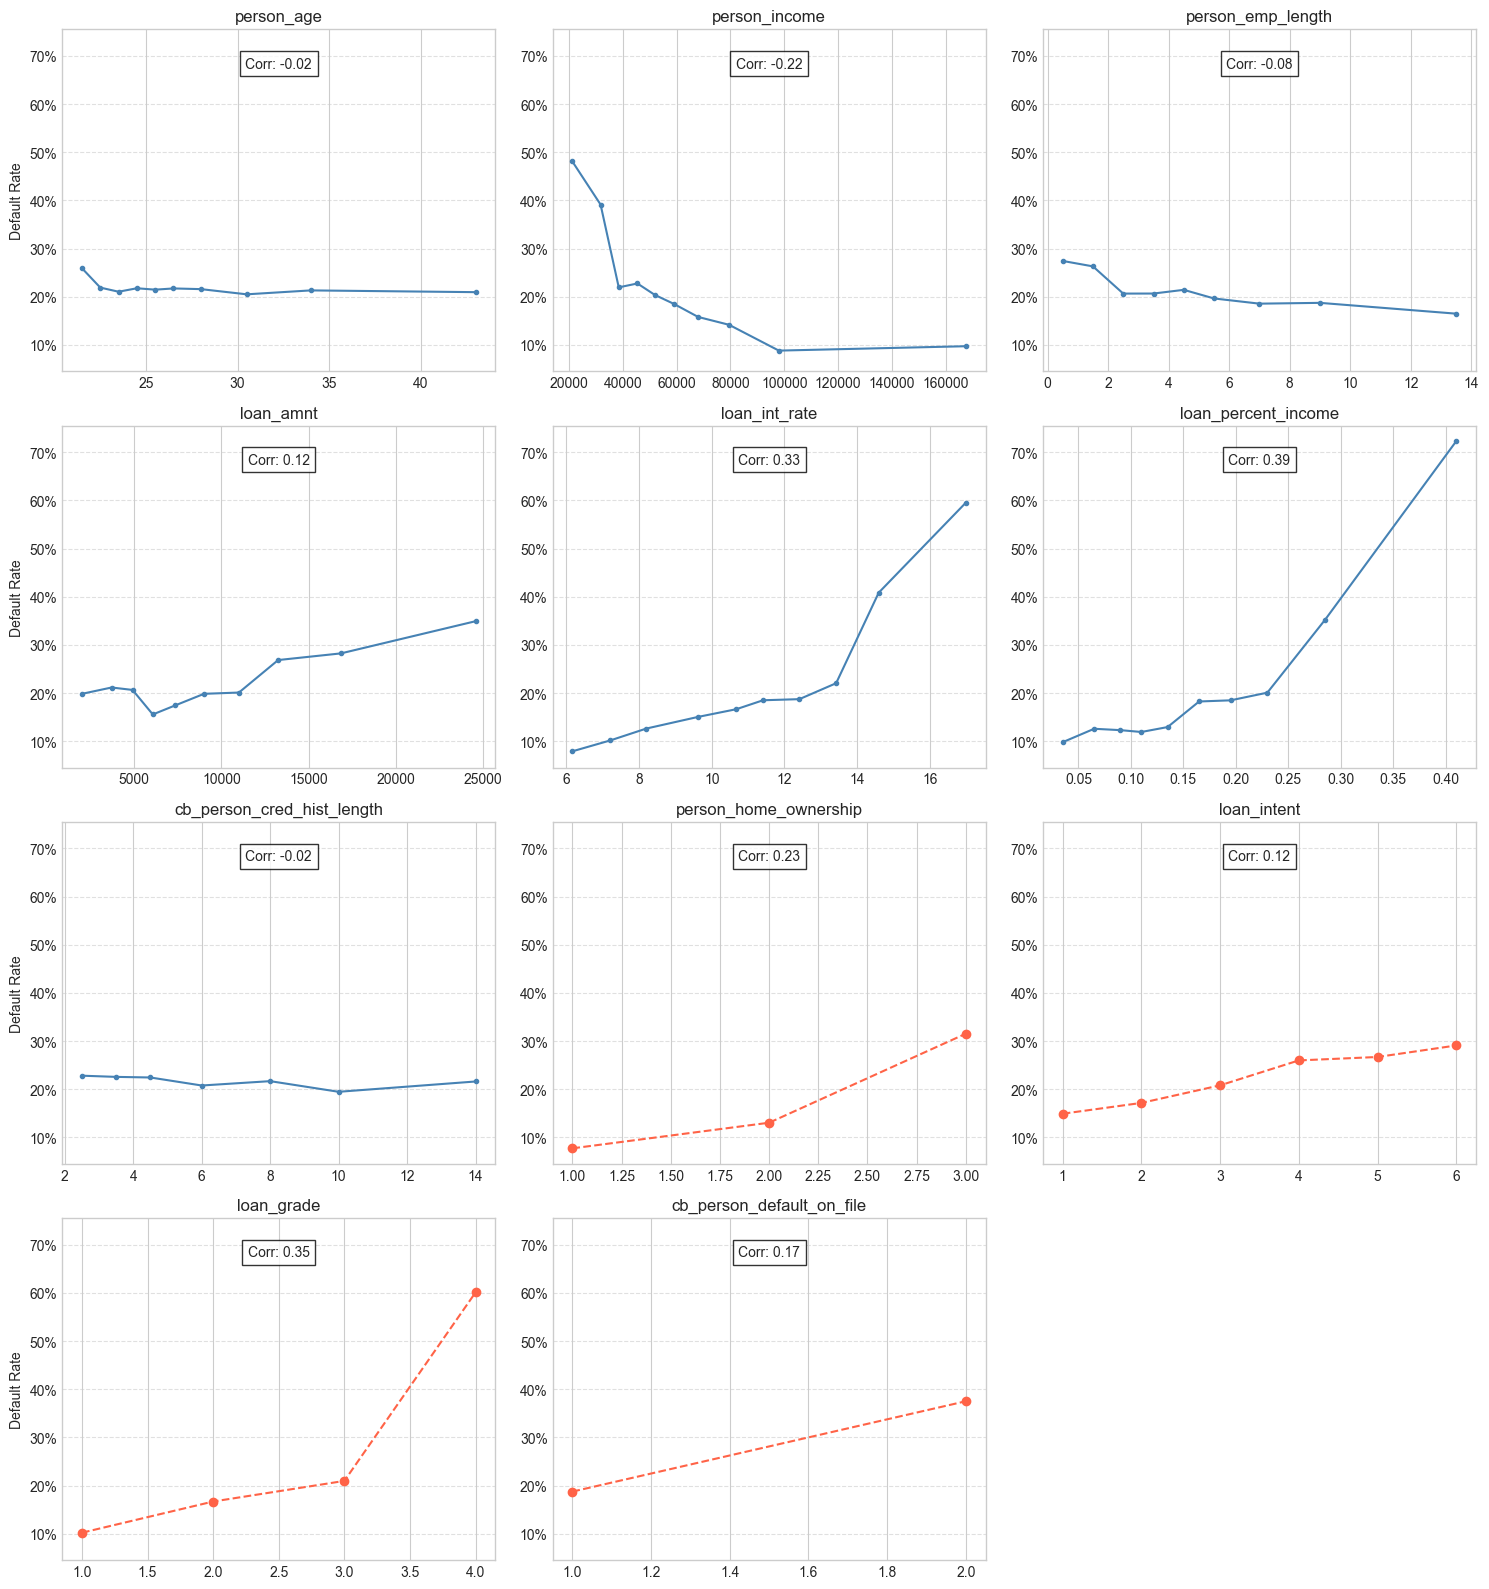

In [113]:
# --- 1. Pre-calculate plot data and find global y-axis limits ---
plot_data = {}
all_y_values = []

for feature in all_features:
    is_categorical = feature in categorical_features
    
    if is_categorical:
        # For target-encoded features
        grouped = train_df.groupby(feature)['loan_status'].agg(['mean', 'count']).reset_index()
        x_val, y_val = grouped[feature], grouped['mean']
    else:
        # For numerical features, create 10 bins (deciles)
        try:
            binned_feature, bins = pd.qcut(train_df[feature], q=10, retbins=True, duplicates='drop')
            grouped = train_df.groupby(binned_feature)['loan_status'].agg(['mean', 'count'])
            x_val = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
            y_val = grouped['mean'].values
        except ValueError as e:
            print(f"Could not bin feature '{feature}': {e}")
            continue
            
    # Store calculated values for plotting later
    plot_data[feature] = {'x': x_val, 'y': y_val, 'is_cat': is_categorical}
    all_y_values.extend(y_val)

# Determine the global y-axis range with a 5% margin
global_y_min = min(all_y_values)
global_y_max = max(all_y_values)
y_range = global_y_max - global_y_min
y_margin = y_range * 0.05 
# Set the final limits for all plots
final_y_lim = (global_y_min - y_margin, global_y_max + y_margin)


# --- 2. Generate the grid of plots using the calculated data and limits ---
num_plots = len(all_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols # Calculate rows needed

plt.figure(figsize=(num_cols * 5, num_rows * 4))
plt.style.use('seaborn-v0_8-whitegrid')

for i, feature in enumerate(all_features):
    if feature not in plot_data:
        continue

    ax = plt.subplot(num_rows, num_cols, i + 1)
    
    # Retrieve pre-calculated data
    data = plot_data[feature]
    x_val, y_val, is_cat = data['x'], data['y'], data['is_cat']
    
    # Set plot style based on feature type
    plot_color = '#FF6347' if is_cat else '#4682B4'
    plot_marker = 'o' if is_cat else '.'
    plot_linestyle = '--' if is_cat else '-'

    # Create the plot
    ax.plot(x_val, y_val, marker=plot_marker, linestyle=plot_linestyle, color=plot_color)

    if is_cat:
        ax.plot([min(x_val), max(x_val)], [min(x_val), max(x_val)], 
                color='grey', linestyle='--', alpha=0.7)

    # --- Apply the shared y-axis limit ---
    ax.set_ylim(final_y_lim)

    # Formatting
    corr, _ = pointbiserialr(train_df[feature].dropna(), train_df['loan_status'].dropna())
    ax.set_title(feature)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.text(0.5, 0.9, f'Corr: {corr:.2f}', ha='center', va='center', 
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    # Add y-label only to the first plot in each row
    if i % num_cols == 0:
        ax.set_ylabel('Default Rate')

plt.tight_layout()
plt.show()

### Correlation

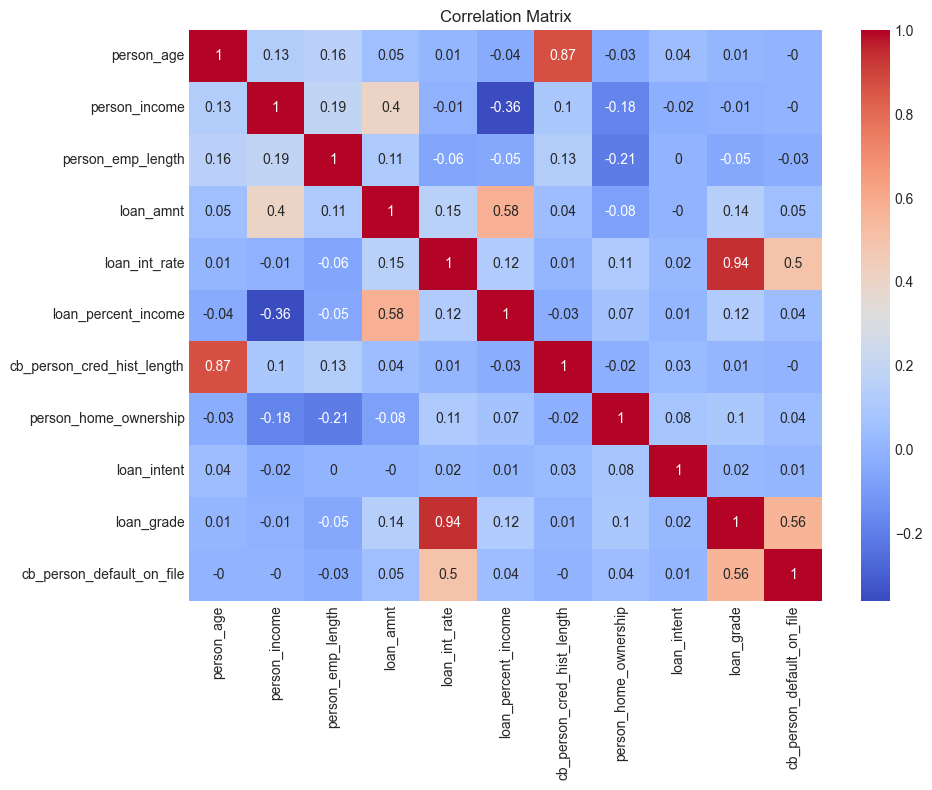

In [115]:
correlation_matrix = train_df[numerical_features+categorical_features].corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

As we see from the correlation heatmap, there are features that are highly correlated, such as `loan_int_rate` & `loan_grade` and `cb_person_cred_hist_length` & `person_age`. 

To be more precise, we can identify causality between `loan_int_rate` and `loan_grade` because the second variable influences the first one. Higher `loan_grade` values correspond to higher `loan_int_rate` values. 

Regarding the high correlation between `cb_person_cred_hist_length` and `person_age`, the relationship is likely due to redundancy rather than causality. Older individuals typically have a longer credit history. However, for modeling purposes, we  retaining `cb_person_cred_hist_length` and dropping `person_age`, as the former is more directly related to creditworthiness.


**Calculatuon of ROC_AUC score for each feature**

In [116]:
roc_auc_feat = {}

for col in numerical_features + categorical_features:
    roc_auc_feat[col] = round(roc_auc_score(train_df[target_variable], train_df[col]),2)

In [117]:
roc_auc_feat

{'person_age': 0.48,
 'person_income': 0.31,
 'person_emp_length': 0.44,
 'loan_amnt': 0.56,
 'loan_int_rate': 0.72,
 'loan_percent_income': 0.73,
 'cb_person_cred_hist_length': 0.49,
 'person_home_ownership': 0.65,
 'loan_intent': 0.59,
 'loan_grade': 0.72,
 'cb_person_default_on_file': 0.58}

**Drop Correlated Features based on Predictive Power**

In [118]:
drop_corr_features = ['person_age', 'loan_int_rate']

In [119]:
train_df.drop(columns=drop_corr_features, inplace=True)
valid_df.drop(columns=drop_corr_features, inplace=True)
test_df.drop(columns=drop_corr_features, inplace=True)

In [120]:
train_df.shape, valid_df.shape, test_df.shape

((20745, 11), (5187, 11), (6484, 11))

In [121]:
# update numerical features
numerical_features.remove('person_age')
numerical_features.remove('loan_int_rate')

## Population Stability Index

**Population Stability Index (PSI)**

Population Stability Index (PSI) is a technique used to measure the stability of a feature over different datasets, such as train and validation sets. It helps in identifying if the distribution of a feature has changed significantly over time or between different datasets. A high PSI value indicates a significant shift in the distribution, which may affect the model's performance.

Steps to calculate PSI:
1. Divide the feature values into bins.
2. Calculate the percentage of observations in each bin for both datasets.
3. Compute the PSI value using the formula:

$$ \text{PSI} = \sum \left( \text{Actual\%} - \text{Expected\%} \right) \times \ln \left( \frac{\text{Actual\%}}{\text{Expected\%}} \right) $$


Where:
- Actual_percent: Percentage of observations in each bin for the validation set.
- Expected_percent: Percentage of observations in each bin for the training set.

PSI Interpretation:
- PSI < 0.1: No significant change.
- 0.1 <= PSI < 0.25: Moderate change.
- PSI >= 0.25: Significant change.

In [ ]:
# Define empty dictionary to store PSI values
psi_values = {}

# Calculate PSI for numerical features
for feature in numerical_features:
    train_values = train_df[feature].dropna().values  # Remove NaN values
    valid_values = valid_df[feature].dropna().values  # Remove NaN values
    psi_values[feature] = calculate_psi(train_values, valid_values, buckets=10)

# Calculate PSI for categorical features
for feature in categorical_features:
    # Normalize value counts to get proportions
    train_values = train_df[feature].value_counts(normalize=True)
    valid_values = valid_df[feature].value_counts(normalize=True)
    psi_values[feature] = calculate_categorical_psi(train_values, valid_values)

# Print PSI values for all features
for feature, psi in psi_values.items():
    print(f"PSI for {feature}: {psi}")

All features are stable, we shouldn't drop none of them!

**Save Final Datasets**

In [123]:
train_df.to_csv('DATA/preprocessed_train.csv', index=False)
valid_df.to_csv('DATA/preprocessed_valid.csv', index=False)
test_df.to_csv('DATA/preprocessed_test.csv', index=False)